# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

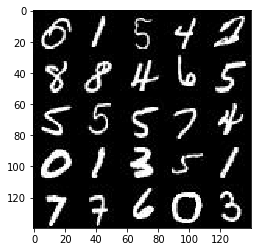

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

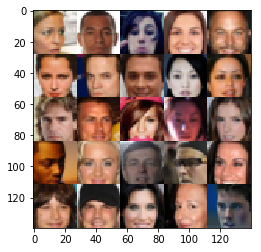

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [50]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [74]:
def leaky_relu(x, alpha):
    """
    A Leaky Rectified Linear Unit
    :param x: Input tensor
    :param alpha: Slope of the leaky output
    :return: Output tensor
    """
    return tf.maximum(alpha * x, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [75]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 0: 28x28x3 -> 14x14x64
        layer0 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer0 = leaky_relu(layer0, alpha)
        
        # Layer 1: 14x14x64 -> 7x7x128
        layer1 = tf.layers.conv2d(layer0, 128, 5, strides=2, padding='same')
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)
        
        # Layer 2: 4x4x256
        layer2 = tf.layers.conv2d(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        
        # Fully connected logits: 4x4x256 -> 4*4*256
        logits = tf.reshape(layer2, [-1, 4*4*256])
        logits = tf.contrib.layers.fully_connected(
            logits, 1, activation_fn=None, 
            weights_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
            biases_initializer=tf.zeros_initializer()
        )
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [76]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 0 (fully connected): z -> 4x4x512
        layer0 = tf.contrib.layers.fully_connected(
            z, 4*4*512, activation_fn=None, 
            weights_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01),
            biases_initializer=tf.zeros_initializer()
        )
        layer0 = tf.reshape(layer0, [-1, 4, 4, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)
        
        # Layer 1: 4x4x512 -> 7x7x256
        layer1 = tf.layers.conv2d_transpose(layer0, 256, 4, strides=1, padding='valid')
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        
        # Layer 2: 7x7x256 -> 14x14x128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        
        # Output image: 14x14x128 -> 28x28x3
        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discriminators, one for real images, and one for fake (generated)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # For a real image, discriminator loss is deviation from an output of 1 (true)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_output_real)
    ))
    
    # For a fake image, discriminator loss is deviation from an output of 0 (false)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)
    ))
    
    # Total discriminator loss is the sum of the real and fake image losses
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss is the opposite of the discriminator loss for fake images
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_output_fake)
    ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get all variables
    t_vars = tf.trainable_variables()
    
    # Get weights and biases for the discriminator and generator
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale the domain from (-0.5, 0.5) to (-1, 1), since we are using tanh in that range
                batch_images = batch_images * 2
                
                # Noise (Z) input for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimize weights and biases
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    g_train_loss = g_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.2300
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 1.4697
Epoch 1/2... Discriminator Loss: 0.2249... Generator Loss: 1.8962
Epoch 1/2... Discriminator Loss: 0.2634... Generator Loss: 4.2218
Epoch 1/2... Discriminator Loss: 0.3016... Generator Loss: 2.0950
Epoch 1/2... Discriminator Loss: 0.2827... Generator Loss: 3.1361
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 3.8518
Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 4.5340
Epoch 1/2... Discriminator Loss: 0.1153... Generator Loss: 2.6928
Epoch 1/2... Discriminator Loss: 0.1929... Generator Loss: 2.8939


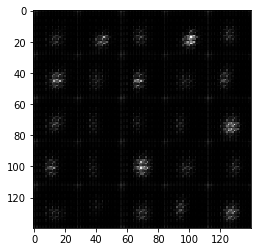

Epoch 1/2... Discriminator Loss: 0.1353... Generator Loss: 3.1304
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 1.6161
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 3.4443
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.1640
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 1.9059
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 2.2738
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 0.7514... Generator Loss: 1.2279


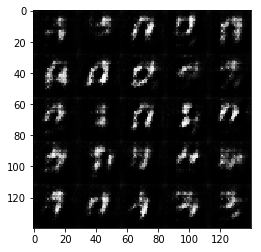

Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.4358
Epoch 1/2... Discriminator Loss: 0.6396... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.5551
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 3.0506
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 0.8117


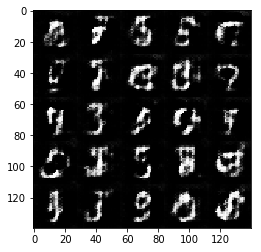

Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 3.1218
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.4924
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 1.2111
Epoch 1/2... Discriminator Loss: 0.7559... Generator Loss: 1.0815


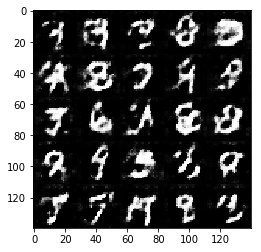

Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 1.3069
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.1655
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 1.4966
Epoch 1/2... Discriminator Loss: 0.7403... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.4774


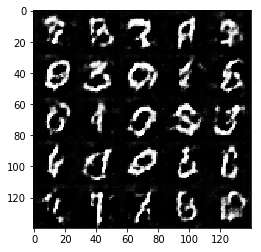

Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.6988
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 0.8252
Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 1.7206
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.3636
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.8677


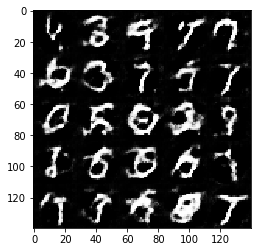

Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.3323
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.6852
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 0.9588
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 0.9516


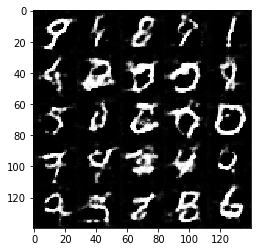

Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.5965
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.9594
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 2.0905
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.3261


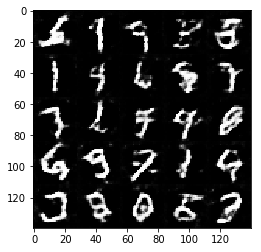

Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.1871
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 1.7823... Generator Loss: 2.1721
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.0618
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 0.9613


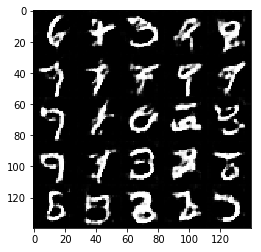

Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 2.1415
Epoch 1/2... Discriminator Loss: 0.7404... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.3115
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 1.0372
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.9125
Epoch 2/2... Discriminator Loss: 1.4869... Generator Loss: 3.0349


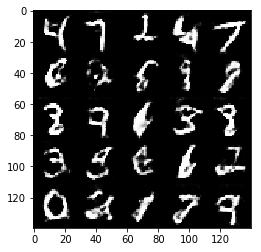

Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 0.6196
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 0.6429... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.2987


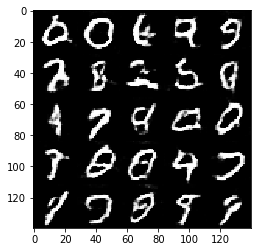

Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.4972
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 0.6618... Generator Loss: 1.1073
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 0.9573


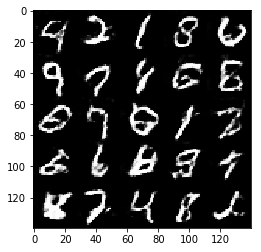

Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.4628
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.0052
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.4996
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.3780
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 2.8757... Generator Loss: 3.9820
Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 0.8268


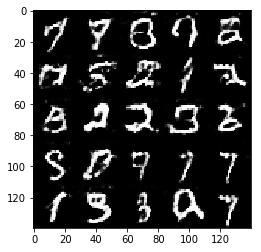

Epoch 2/2... Discriminator Loss: 1.9510... Generator Loss: 3.4590
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 1.9523
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 0.9790
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.0696


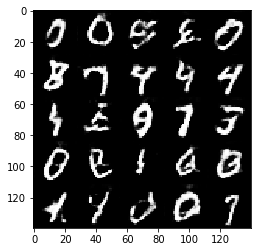

Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.5493
Epoch 2/2... Discriminator Loss: 0.7576... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.3342
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 2.8804... Generator Loss: 0.0752
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.7540
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.1268


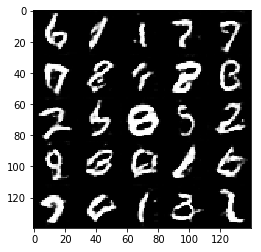

Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 2.0698
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 2.6066
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.2887
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 0.8779
Epoch 2/2... Discriminator Loss: 0.6402... Generator Loss: 1.0136
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 2.9532


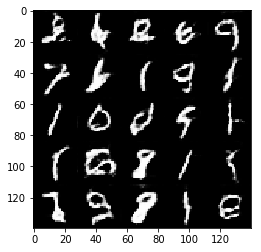

Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.1545
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 2.1037
Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.4213
Epoch 2/2... Discriminator Loss: 1.8314... Generator Loss: 0.3069
Epoch 2/2... Discriminator Loss: 0.5989... Generator Loss: 1.2060
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.4139


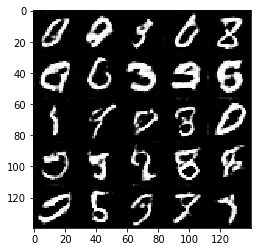

Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.3884
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.4514... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 0.6435... Generator Loss: 1.3326
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 0.5981... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.4800
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 1.3590


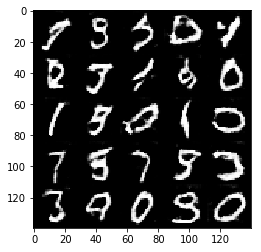

Epoch 2/2... Discriminator Loss: 2.5230... Generator Loss: 4.3257
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.4967
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.3118
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 0.8756... Generator Loss: 0.7747


In [87]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 1.9707
Epoch 1/1... Discriminator Loss: 0.2007... Generator Loss: 2.2077
Epoch 1/1... Discriminator Loss: 0.3208... Generator Loss: 1.8978
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 0.1403... Generator Loss: 2.4548
Epoch 1/1... Discriminator Loss: 0.2118... Generator Loss: 1.9291
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 4.3124
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.1757


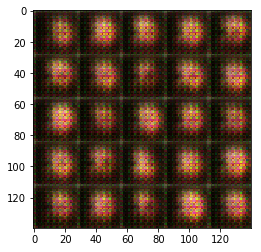

Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 2.1578
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 6.8646
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 2.0702
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 2.5695
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.4199
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.2493


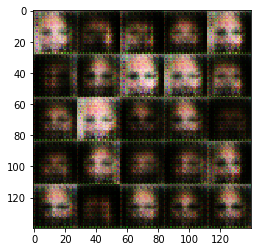

Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.3167


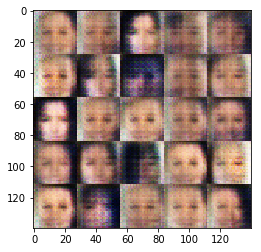

Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 1.4398
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7604


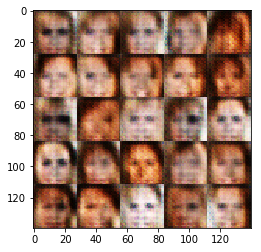

Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 2.9663
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 2.3158
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 2.1104... Generator Loss: 3.0532
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.0747


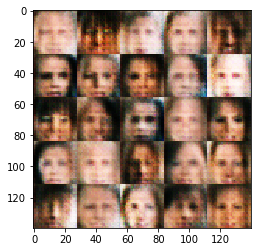

Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.7467
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.8262
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.3535


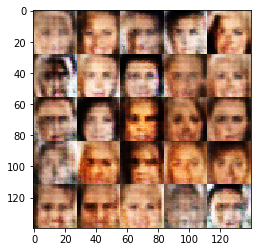

Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 2.5332
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.8327
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.6785


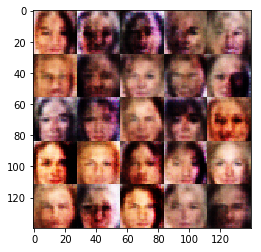

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 2.1268
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 2.7941
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 2.1066
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 2.5342


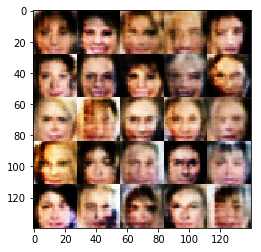

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 1.7180
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.9648
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 3.2160
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 3.7738
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 2.2779
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 3.3319


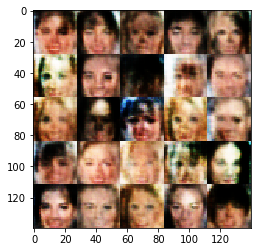

Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 2.2165
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 2.4802
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 4.9960
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 0.8307


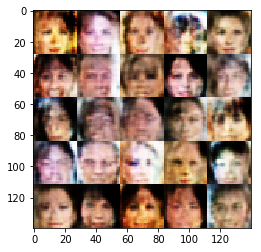

Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 2.4807
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.4992
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 2.9968
Epoch 1/1... Discriminator Loss: 0.3136... Generator Loss: 2.5885
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 3.2308
Epoch 1/1... Discriminator Loss: 0.2116... Generator Loss: 2.2135
Epoch 1/1... Discriminator Loss: 0.2248... Generator Loss: 2.7756
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 1.3631


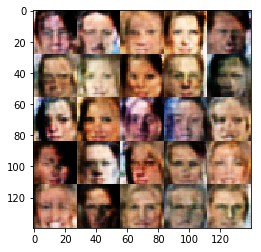

Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 5.3771
Epoch 1/1... Discriminator Loss: 0.3065... Generator Loss: 2.8975
Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 2.0597
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 3.1163
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 4.5560
Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 1.8546
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 2.8986


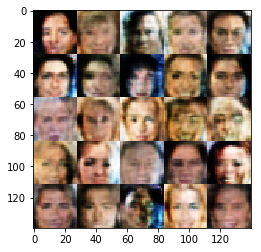

Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 3.2068
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 6.1293
Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 4.0460
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 4.1795
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 3.0896
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 0.9557


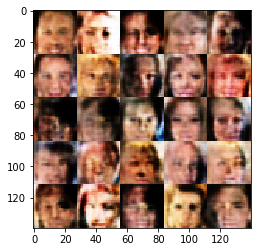

Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 2.0705
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 2.7544
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 4.7942
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 0.2156... Generator Loss: 2.5213
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.0331
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 6.8369


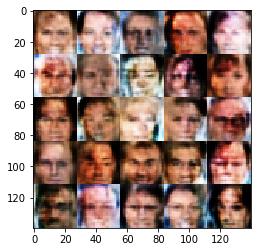

Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 4.8674
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 4.4835
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 3.9441
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 2.2039
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 4.4579
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 4.4174
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 5.0771
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 4.4031


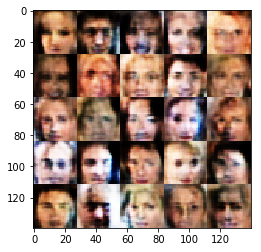

Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 1.7109
Epoch 1/1... Discriminator Loss: 0.2321... Generator Loss: 2.3217
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 4.0034
Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 2.2240
Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 0.1203... Generator Loss: 3.5494
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 3.5097
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 3.0969
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 4.2312


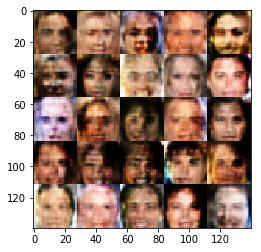

Epoch 1/1... Discriminator Loss: 0.1615... Generator Loss: 3.5958
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.5516
Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 3.8755
Epoch 1/1... Discriminator Loss: 0.1480... Generator Loss: 2.9564
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 4.5671
Epoch 1/1... Discriminator Loss: 0.3212... Generator Loss: 1.6199
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 4.2751
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 7.3853
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 4.0051


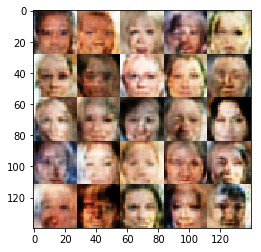

Epoch 1/1... Discriminator Loss: 0.2123... Generator Loss: 3.3408
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 3.4014
Epoch 1/1... Discriminator Loss: 0.1166... Generator Loss: 3.3138
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 3.8541
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 6.3199
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.3011
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 1.6536


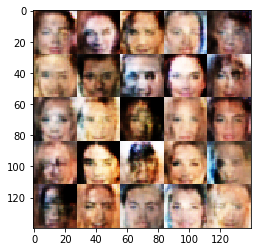

Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 2.5588
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 3.2872
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 4.4999
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 2.2506
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 3.2885
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 4.4881
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.1079... Generator Loss: 3.1866


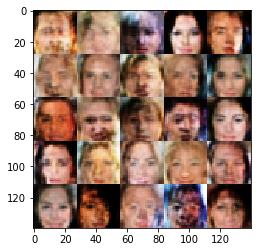

Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 3.1812
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.6361
Epoch 1/1... Discriminator Loss: 0.0969... Generator Loss: 3.6335
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 2.7578
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.1609... Generator Loss: 3.5183
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 3.1327
Epoch 1/1... Discriminator Loss: 0.1459... Generator Loss: 3.8951
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 3.9413
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 4.3701


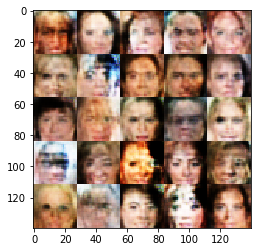

Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 3.1908
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 3.6826
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 2.4147
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 3.8454
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.5483
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 1.9955
Epoch 1/1... Discriminator Loss: 0.1169... Generator Loss: 3.4890
Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 7.1519
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 1.6297


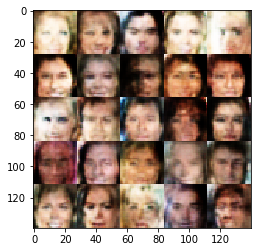

Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 2.1895
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 4.0724
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 3.1269
Epoch 1/1... Discriminator Loss: 0.0888... Generator Loss: 6.0037
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 3.9999
Epoch 1/1... Discriminator Loss: 0.1701... Generator Loss: 2.6458
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.6149
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 3.7405


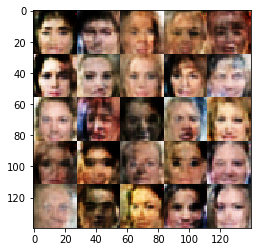

Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 4.0278
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 3.5501
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 1.6533
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.2902... Generator Loss: 5.2634
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 2.5015
Epoch 1/1... Discriminator Loss: 0.1272... Generator Loss: 3.2186
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 2.7858
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 3.4737


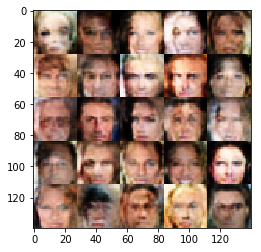

Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 2.3208
Epoch 1/1... Discriminator Loss: 0.1774... Generator Loss: 3.8620
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.2719... Generator Loss: 1.9074
Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 3.6055
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 2.2170
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 3.1981
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 5.0904
Epoch 1/1... Discriminator Loss: 0.2323... Generator Loss: 5.5703
Epoch 1/1... Discriminator Loss: 0.3108... Generator Loss: 4.8119


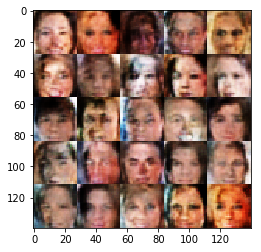

Epoch 1/1... Discriminator Loss: 1.8474... Generator Loss: 4.5517
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 1.8769... Generator Loss: 0.2551
Epoch 1/1... Discriminator Loss: 0.2522... Generator Loss: 3.4671
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 4.4273
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 1.7953
Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 3.0742
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 4.6955
Epoch 1/1... Discriminator Loss: 0.1063... Generator Loss: 4.5774


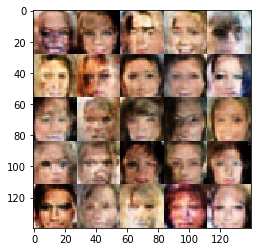

Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 0.1649... Generator Loss: 4.8809
Epoch 1/1... Discriminator Loss: 0.1705... Generator Loss: 2.8378
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.5663
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 2.7297
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.7327
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 4.5277
Epoch 1/1... Discriminator Loss: 0.0888... Generator Loss: 3.9025
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.2853


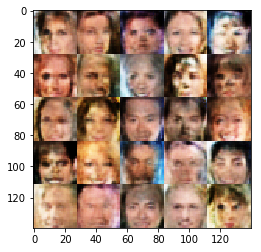

Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 3.9579
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.5532
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 2.7859
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 5.3202
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 1.9755
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 2.0989


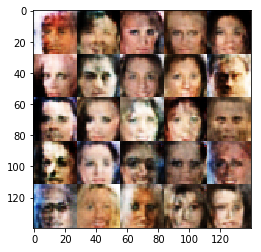

Epoch 1/1... Discriminator Loss: 0.0904... Generator Loss: 5.3165
Epoch 1/1... Discriminator Loss: 0.1495... Generator Loss: 3.2952
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.8513
Epoch 1/1... Discriminator Loss: 0.0961... Generator Loss: 3.9507
Epoch 1/1... Discriminator Loss: 0.2613... Generator Loss: 2.0429
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 2.8596
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 5.7182
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 2.7975
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 3.7892


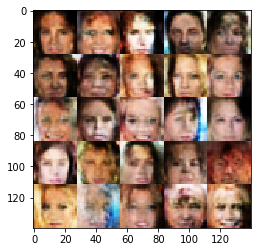

Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 3.1202
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.5382
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 5.5144
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.5317
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 1.9370


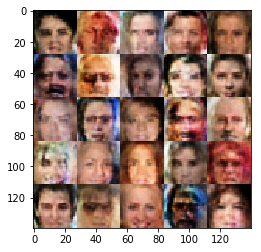

Epoch 1/1... Discriminator Loss: 0.3107... Generator Loss: 1.7971
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.4619
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 1.8059
Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 3.2560
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 1.5698


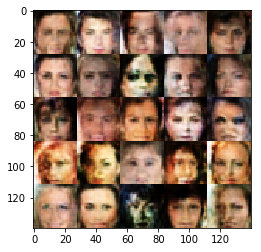

Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 5.0214
Epoch 1/1... Discriminator Loss: 0.2309... Generator Loss: 2.4214
Epoch 1/1... Discriminator Loss: 0.3166... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 2.1328
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 4.5376
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 3.1537
Epoch 1/1... Discriminator Loss: 0.2506... Generator Loss: 1.9861
Epoch 1/1... Discriminator Loss: 0.1425... Generator Loss: 2.6225


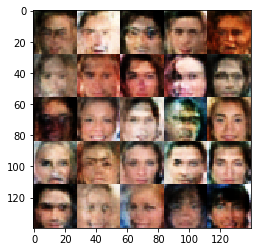

Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 3.5024
Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.1128... Generator Loss: 2.9137
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 2.8099


In [88]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.